In [ ]:
# Dataframe
import pandas as pd

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#Regular Expressions
import re

# Maptplolib
import matplotlib.pyplot as plt 

#Numpy
import numpy as np 

# Seaborn
import seaborn as sns 

# Scikit-learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


import nltk
nltk.download('stopwords')

import os
from google.colab import drive
from google.colab import files

np.set_printoptions(suppress=True)  # no usar notacion "e"

# Librerias para Analisis y optimizacion de los parametros
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Liberias para calcular las metricas
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import pairwise_distances_argmin_min
#custering
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition
from sklearn.mixture import GaussianMixture


import itertools
import warnings
warnings.filterwarnings("ignore")
import io



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#cargar el dataset

upload = files.upload()

Saving sentPositiveall-data.csv to sentPositiveall-data.csv


In [ ]:

# # Alternativa google drive
# # Declaramos la ruta principal
# google_drive = "/content/gdrive"
# root_path = os.path.join(google_drive, "My Drive", "Colab Notebooks", "Mentoria_Datasets")

In [ ]:
# drive.mount(google_drive, force_remount = True)

In [ ]:
# load dataset

news_df = pd.read_csv(("sentPositiveall-data.csv"), names=["label", "text"], encoding = "ISO-8859-1")
#news_df = pd.read_csv(os.path.join(root_path, "sentPositiveall-data.csv"), names=["label", "text"], encoding = "ISO-8859-1")

#news_df = pd.read_csv("C:/Users/DTC21/Google Drive/!Repo/DiploDatos/Mentorias/mentodatos-safnfi-2022-GrupoB-main/mentodatos-safnfi-2022-GrupoB-main/segundaentrega/sentPositiveall-data.csv", names=["label", "messages"], encoding = "ISO-8859-1")
#pd.read_csv('../input/sentiment-analysis-for-financial-news/all-data.csv',names = ['lables','messages'])
news_df.head()

,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
# Check for nulll values
news_df.isnull().sum()

label    0
text     0
dtype: int64

In [ ]:
# Shape of our dataset
news_df.shape

(4846, 2)

In [ ]:
df_copy = news_df.copy()
df_copy.head()

,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


# Map target label to String
 0 -> NEGATIVE
 2 -> NEUTRAL
 4 -> POSITIVE

In [ ]:
# Map target label to String
# -1 -> NEGATIVE
# 0 -> NEUTRAL
# 1 -> POSITIVE

def func(df):
    if df == 'neutral':
        return 0
    elif df == 'negative':
        return -1
    else:
        return 1
df_copy['target'] = df_copy.label.apply(func)
df_copy.head()

,label,text,target
0,neutral,"According to Gran , the company has no plans t...",0
1,neutral,Technopolis plans to develop in stages an area...,0
2,negative,The international electronic industry company ...,-1
3,positive,With the new production plant the company woul...,1
4,positive,According to the company 's updated strategy f...,1


# Count plot for labels feature

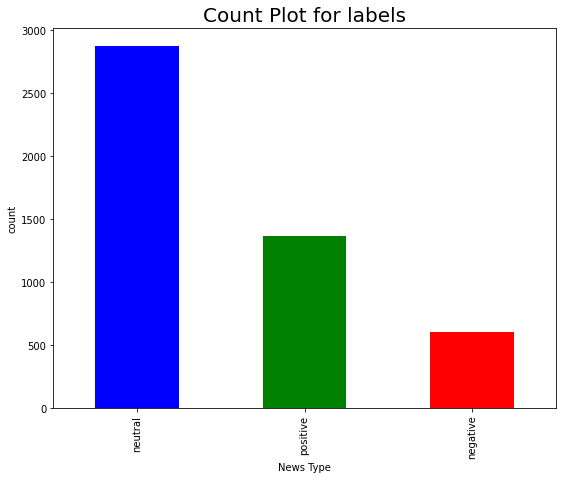

In [ ]:
plt.figure(figsize=(9,7))
df_copy.label.value_counts().plot(kind='bar',color=['blue','green','red'])
plt.xlabel("News Type")
plt.ylabel("count")
plt.title("Count Plot for labels",{'fontsize':20});

# Text preprocessing

In [ ]:
corpous = list()

#Object for porterstem
ps = PorterStemmer()

for i in range(len(df_copy)):
    text = re.sub(r'[^a-zA-Z]',' ',df_copy.text[i])  
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if word not in set(stopwords.words('english'))]
    text = ' '.join(text)
    corpous.append(text)


APLICANDO WORD2VEC

In [ ]:
import gensim
x_tokenized = [[w for w in sentence.split(" ") if w != ""] for sentence in corpous]
x_tokenized[0]

['accord',
 'gran',
 'compani',
 'plan',
 'move',
 'product',
 'russia',
 'although',
 'compani',
 'grow']

In [ ]:
import time

start = time.time()

model = gensim.models.Word2Vec(x_tokenized)
                 # Size is the length of our vector.
                

end = round(time.time()-start,2)
print("This process took",end,"seconds.")

This process took 0.73 seconds.


In [ ]:
model.wv.most_similar("total")

[('decreas', 0.9997344613075256),
 ('sale', 0.9990910291671753),
 ('first', 0.9987675547599792),
 ('month', 0.9986872673034668),
 ('oper', 0.998387336730957),
 ('million', 0.9978161454200745),
 ('tax', 0.9974114894866943),
 ('year', 0.9972115755081177),
 ('third', 0.9966381788253784),
 ('ebit', 0.9963447451591492)]

In [ ]:
class Sequencer():
    
    def __init__(self,
                 all_words,
                 max_words,
                 seq_len,
                 embedding_matrix
                ):
        
        self.seq_len = seq_len
        self.embed_matrix = embedding_matrix
        """
        temp_vocab = Vocab which has all the unique words
        self.vocab = Our last vocab which has only most used N words.
    
        """
        temp_vocab = list(set(all_words))
        self.vocab = []
        self.word_cnts = {}
        """
        Now we'll create a hash map (dict) which includes words and their occurencies
        """
        for word in temp_vocab:
            # 0 does not have a meaning, you can add the word to the list
            # or something different.
            count = len([0 for w in all_words if w == word])
            self.word_cnts[word] = count
            counts = list(self.word_cnts.values())
            indexes = list(range(len(counts)))
        
        # Now we'll sort counts and while sorting them also will sort indexes.
        # We'll use those indexes to find most used N word.
        cnt = 0
        while cnt + 1 != len(counts):
            cnt = 0
            for i in range(len(counts)-1):
                if counts[i] < counts[i+1]:
                    counts[i+1],counts[i] = counts[i],counts[i+1]
                    indexes[i],indexes[i+1] = indexes[i+1],indexes[i]
                else:
                    cnt += 1
        
        for ind in indexes[:max_words]:
            self.vocab.append(temp_vocab[ind])
                    
    def textToVector(self,text):
        # First we need to split the text into its tokens and learn the length
        # If length is shorter than the max len we'll add some spaces (100D vectors which has only zero values)
        # If it's longer than the max len we'll trim from the end.
        tokens = text.split()
        len_v = len(tokens)-1 if len(tokens) < self.seq_len else self.seq_len-1
        vec = []
        for tok in tokens[:len_v]:
            try:
                vec.append(self.embed_matrix[tok])
            except Exception as E:
                pass
        
        last_pieces = self.seq_len - len(vec)
        for i in range(last_pieces):
            vec.append(np.zeros(100,))
        
        return np.asarray(vec).flatten()
                

In [ ]:
len(max(x_tokenized, key=len))

41

In [ ]:
sequencer = Sequencer(all_words = [token for seq in x_tokenized for token in seq],
              max_words = 1200,
              seq_len = 41,
              embedding_matrix = model.wv
             )

In [ ]:
test_vec = sequencer.textToVector("million user decemb market share number")
test_vec

array([-0.34326476,  0.38189843,  0.2876021 , ...,  0.        ,
        0.        ,  0.        ])

In [ ]:
test_vec.shape

(3300,)

In [ ]:
#alternativa countvectorizer

# from sklearn.feature_extraction.text import CountVectorizer
# cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
# X = cv.fit_transform(corpous).toarray()

In [ ]:
# let's create
# vectors for our each vector
X = np.asarray([sequencer.textToVector(" ".join(seq)) for seq in x_tokenized])
print(X.shape)

(4846, 3300)


In [ ]:
# Dependent Feature
y = df_copy.target

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters


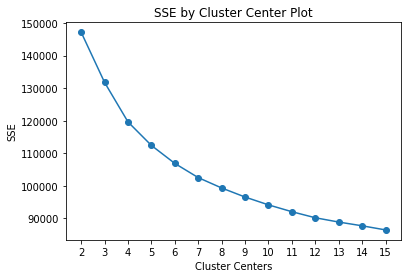

In [ ]:

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, random_state=20).fit(X).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(sequencer.textToVector, 15)

In [ ]:
# Número de clusters buscado
n_clust = 5

km = KMeans(n_clusters=n_clust, random_state=0)
km.fit(X) 

# Etiquetas asignadas por el algoritmo
clusters = km.labels_


In [ ]:
df_clusters=df_copy.copy()
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
df_clusters.head(200)

Kmeans encontró:  5 clusters, nosotros forzamos la cantidad


,label,text,target,kmeans
0,neutral,"According to Gran , the company has no plans t...",0,0
1,neutral,Technopolis plans to develop in stages an area...,0,1
2,negative,The international electronic industry company ...,-1,3
3,positive,With the new production plant the company woul...,1,3
4,positive,According to the company 's updated strategy f...,1,3
...,...,...,...,...
195,positive,Finnish messaging solutions developer Tecnomen...,1,3
196,positive,Finnish metal industry solutions supplier Outo...,1,3
197,positive,Finnish metal products company Componenta Oyj ...,1,3
198,positive,Finnish office supplies and computer accessori...,1,3


In [ ]:
labels = km.labels_
cluster_center=km.cluster_centers_

In [ ]:
cluster_center

array([[-0.17156906,  0.13478155,  0.11808649, ...,  0.        ,
         0.        ,  0.        ],
       [-0.14947348,  0.10824122,  0.09836872, ...,  0.        ,
         0.        ,  0.        ],
       [-0.15565469,  0.12338611,  0.10808567, ...,  0.        ,
         0.        ,  0.        ],
       [-0.16555514,  0.11586646,  0.10567203, ...,  0.        ,
         0.        ,  0.        ],
       [-0.23887149,  0.24015829,  0.18733193, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
from sklearn import metrics
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')

In [ ]:
# which tells us that clusters are far away from each other 
silhouette_score

0.12624114708037168

In [ ]:
# How many points belong to each cluster -> using group by in pandas
df_clusters.groupby(['kmeans'])['text'].count()

kmeans
0    1150
1    1506
2     618
3    1227
4     345
Name: text, dtype: int64

In [ ]:
# #Refrence credit - to find the top 10 features of cluster centriod
# #https://stackoverflow.com/questions/47452119/kmean-clustering-top-terms-in-cluster
# print("Top terms per cluster:")
# order_centroids = km.cluster_centers_.argsort()[:, ::-1]
# terms = sequencer.textToVector.get_feature_names()
# for i in range(5):
#     print("Cluster %d:" % i, end='')
#     for ind in order_centroids[i, :10]:
#         print(' %s' % terms[ind], end='')
#         print()

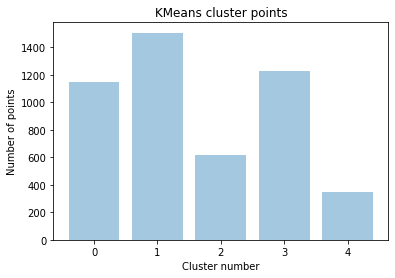

In [ ]:
# visually how points or reviews are distributed across 10 clusters 
import matplotlib.pyplot as plt
plt.bar([x for x in range(5)], df_clusters.groupby(['kmeans'])['text'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [ ]:
# Reading a review which belong to each group.
for i in range(5):
    print("A review of assigned to cluster ", i)
    print("-" * 70)
    print(df_clusters.iloc[df_clusters.groupby(['kmeans']).groups[i][0]]['text'])
    print('\n')
    print("_" * 70)

A review of assigned to cluster  0
----------------------------------------------------------------------
Lifetree was founded in 2000 , and its revenues have risen on an average by 40 % with margins in late 30s .


______________________________________________________________________
A review of assigned to cluster  1
----------------------------------------------------------------------
According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


______________________________________________________________________
A review of assigned to cluster  2
----------------------------------------------------------------------
The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .


_____________________________________________________________________

In [ ]:

# check whether the words are clustered correctly
print(km.predict(X))

[0 1 3 ... 4 3 0]


In [ ]:
#Tokens más cercanos al centro, + representativos de cada cluster

# find the index and the distance of the closest points from x to each class centroid

close = pairwise_distances_argmin_min(km.cluster_centers_, X, metric='euclidean')
index_closest_points = close[0]
distance_closest_points = close[1]

for i in range(0, n_clust):
    print("The closest token to the centroid of class {0} is {1}, the distance is {2}".format(i, x_tokenized[index_closest_points[i]], distance_closest_points[i]))
    #print("The closest token to the centroid of class {0} is {1}, the distance is {2}".format(i, corpous[index_closest_points[i]], distance_closest_points[i]))

The closest token to the centroid of class 0 is ['replay', 'avail', 'octob', 'follow', 'number', 'us', 'caller', 'non', 'us', 'caller', 'access', 'code'], the distance is 1.574794344834362
The closest token to the centroid of class 0 is replay avail octob follow number us caller non us caller access code, the distance is 1.574794344834362
The closest token to the centroid of class 1 is ['omx', 'nordic', 'omxn', 'index', 'compris', 'trade', 'nordic', 'stock', 'nasdaq', 'omx', 'exchang', 'close', 'point', 'wednesday'], the distance is 2.6219982840145364
The closest token to the centroid of class 1 is omx nordic omxn index compris trade nordic stock nasdaq omx exchang close point wednesday, the distance is 2.6219982840145364
The closest token to the centroid of class 2 is ['personnel', 'reduct', 'carri', 'anjalankoski', 'hollola', 'jyvaskyla', 'jarvenpaa', 'karhula', 'turku', 'valkeakoski', 'unit'], the distance is 0.6923937824902284
The closest token to the centroid of class 2 is personn

In [ ]:
from sklearn.decomposition import PCA

# fit a 2d PCA model to the vectors
vectors = model[model.wv.vocab]
words = list(model.wv.vocab)
pca = PCA(n_components=2)
PCA_result = pca.fit_transform(vectors)

In [ ]:
# prepare a dataframe
words = pd.DataFrame(words)
PCA_result = pd.DataFrame(PCA_result)
PCA_result['x_values'] =PCA_result.iloc[0:, 0]
PCA_result['y_values'] =PCA_result.iloc[0:, 1]
PCA_final = pd.merge(words, PCA_result, left_index=True, right_index=True)
PCA_final['word'] =PCA_final.iloc[0:, 0]
PCA_data_complet =PCA_final[['word','x_values','y_values']]

In [ ]:
PCA_data_complet

,word,x_values,y_values
0,accord,2.300695,-0.351272
1,compani,2.160072,-0.345827
2,plan,2.050919,-0.309110
3,move,0.612199,-0.010347
4,product,2.484590,-0.578938
...,...,...,...
1756,strike,-0.610478,0.038937
1757,block,-0.595321,-0.010788
1758,expir,-0.897842,0.037987
1759,lassila,-0.826580,0.019491


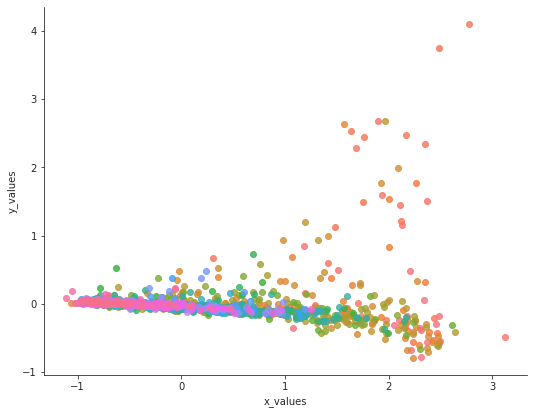

In [ ]:

import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style('ticks')
fig = sns.lmplot(x='x_values', y='y_values',
           data = PCA_data_complet,
           fit_reg=False,
           legend=False,
           hue='word')
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.show()

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_kmeans = tsne_model.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4846 samples in 0.012s...
[t-SNE] Computed neighbors for 4846 samples in 2.917s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4846
[t-SNE] Computed conditional probabilities for sample 2000 / 4846
[t-SNE] Computed conditional probabilities for sample 3000 / 4846
[t-SNE] Computed conditional probabilities for sample 4000 / 4846
[t-SNE] Computed conditional probabilities for sample 4846 / 4846
[t-SNE] Mean sigma: 1.246482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.338364
[t-SNE] KL divergence after 1000 iterations: 1.677932


In [ ]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis 

output_notebook()
plot_kmeans = bp.figure(plot_width=900, plot_height=700, title="Sentiment (Word2Vec)",
    tools="pan,wheel_zoom,box_zoom,reset,hover",
    x_axis_type=None, y_axis_type=None, min_border=1)

plot_kmeans.scatter(x=tsne_kmeans[:,0], y=tsne_kmeans[:,1])
                   
hover = plot_kmeans.select(dict(type=HoverTool))

show(plot_kmeans)

In [ ]:
colormap = np.array([
    "#1f77b4", "#ff9896", "#ffbb78" 
])

plot_kmeans = bp.figure(plot_width=800, plot_height=700, title="Sentiment (Clases)",
    tools="pan,wheel_zoom,box_zoom,reset,hover",
    x_axis_type=None, y_axis_type=None, min_border=1)

plot_kmeans.scatter(x=tsne_kmeans[:,0], y=tsne_kmeans[:,1], 
                    color= colormap[y][:5000]) 
                   
hover = plot_kmeans.select(dict(type=HoverTool))

show(plot_kmeans)

En el gráfico anterior se observa la distribución clases 

In [ ]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5", 
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

plot_kmeans = bp.figure(plot_width=800, plot_height=700, title="Sentiment (k-means)",
    tools="pan,wheel_zoom,box_zoom,reset,hover",
    x_axis_type=None, y_axis_type=None, min_border=1)

plot_kmeans.scatter(x=tsne_kmeans[:,0], y=tsne_kmeans[:,1], 
                    color=colormap[clusters][:10000]) 
                   
hover = plot_kmeans.select(dict(type=HoverTool))

show(plot_kmeans)

Así quedan representados los cinco clusters obtenidos con K-Means en un espacio bidimensional graficado con TSNE. Se puede observar que los clusters no coinciden con las clases y que las clases en el espacio bidimensional no se separan espacialmente.

In [ ]:
#PCA con 40 componmentes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

train = X  

train = StandardScaler().fit_transform(train)
train = pd.DataFrame(train).dropna()

pca = PCA(n_components=40)
pca_res = pca.fit_transform(train)
train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,3290,3291,3292,3293,3294,3295,3296,3297,3298,3299
0,-0.830895,0.324412,0.565503,1.233261,-0.969175,0.353003,1.072471,1.367799,-1.259691,0.914486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.204262,-0.985198,-1.104327,-0.804969,1.330758,-0.918031,-1.297322,-1.107553,1.279733,-1.321617,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001286,-0.123831,-0.121374,0.187146,0.010487,-0.161145,0.064933,0.188038,-0.111476,0.018678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pca_res

array([[ -9.56835238,   2.64633878,  -3.31170917, ...,  -0.11373884,
         -0.0549128 ,   0.173666  ],
       [ 14.332122  ,  -7.5433569 ,  -3.56079947, ...,   0.55619844,
         -0.09938101,   0.93407213],
       [ 20.26499977,  -9.72398087,  -2.49571621, ...,  -2.00058828,
          5.88251766,  -0.48010586],
       ...,
       [ -0.99486425, -12.52537228,  52.78380904, ...,   2.79829859,
         -8.09439391,   2.51344549],
       [104.34200623, -25.96452161,  17.88461059, ...,  -9.25519432,
         -8.45523026,  -2.31678633],
       [-12.62685752,   3.08812471,   3.61509538, ..., -13.67522357,
          1.81260571,  -2.98267763]])

In [ ]:
#print(pca.explained_variance_ratio_)


print(pca.explained_variance_ratio_.cumsum())

[0.18036183 0.27842845 0.35347127 0.41442311 0.45881597 0.49398569
 0.52893128 0.55867245 0.58205568 0.60353373 0.62288309 0.64172809
 0.65969346 0.67687092 0.69253859 0.70728687 0.72157462 0.73496608
 0.74796725 0.75939631 0.77048547 0.78085047 0.79090978 0.80012109
 0.80910126 0.81795729 0.82650209 0.83473139 0.84249719 0.85001378
 0.85727793 0.86432098 0.87124599 0.8777842  0.88406428 0.89000184
 0.8958697  0.901506   0.90705082 0.91236834]


In [ ]:
output_notebook()
plot_pca = bp.figure(plot_width=900, plot_height=700, title="PCA",
    tools="pan,wheel_zoom,box_zoom,reset,hover",
    x_axis_type=None, y_axis_type=None, min_border=1)

plot_pca.scatter(x=pca_res[:,0], y=pca_res[:,1])
                   
hover = plot_pca.select(dict(type=HoverTool))

show(plot_pca)

In [ ]:
text_pca= pca.transform(train)

In [ ]:
wcss_pca=[]
for i in range(1,20):
    kmeans_pca=KMeans(n_clusters= i, init='k-means++', random_state=42)
    kmeans_pca.fit(text_pca)
    wcss_pca.append(kmeans_pca.inertia_)

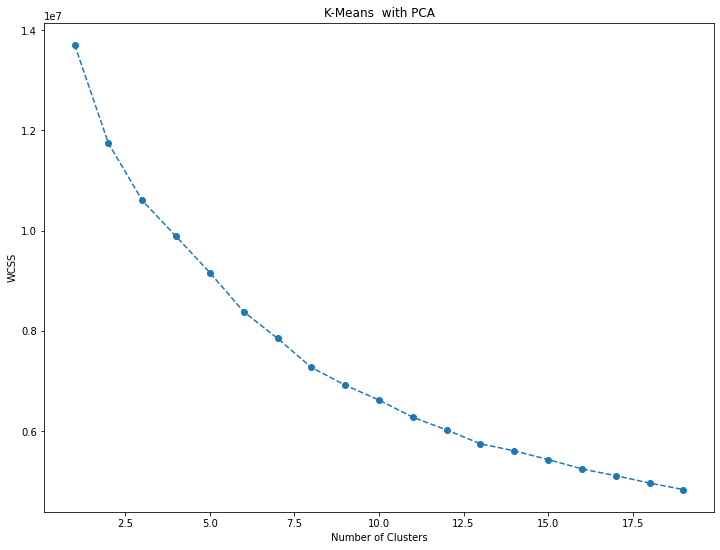

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(range(1,20),wcss_pca, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("K-Means  with PCA")
plt.show()

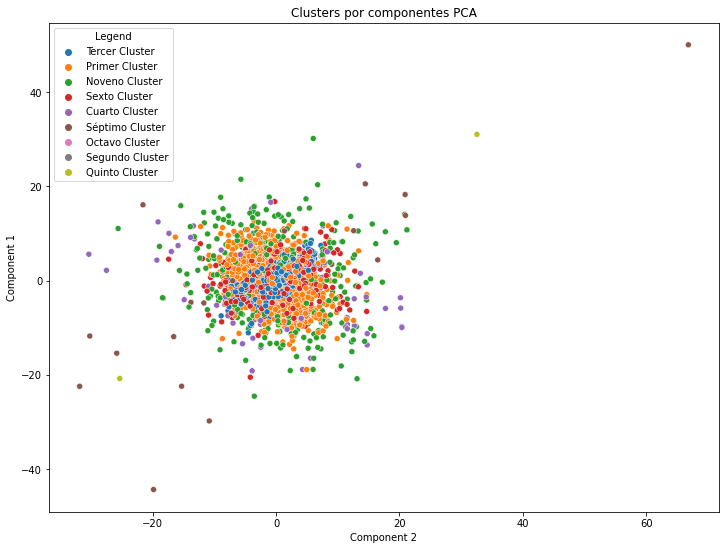

In [ ]:
#K-Means clustering with PCA results
kmeans_pca=KMeans(n_clusters= 9, init='k-means++', random_state=0)
kmeans_pca.fit(text_pca)

df_segm_pca_kmeans= pd.concat([df_clusters.reset_index(drop=True), pd.DataFrame(text_pca)], axis=1)
df_segm_pca_kmeans.columns.values[-2: ]= ['Component 1','Component 2']
df_segm_pca_kmeans['Segment k-means PCA']= kmeans_pca.labels_
df_segm_pca_kmeans_freq= df_segm_pca_kmeans.groupby(['Segment k-means PCA']).mean()

df_segm_pca_kmeans['Legend']= df_segm_pca_kmeans['Segment k-means PCA'].map({0:'Primer Cluster',1:'Segundo Cluster',2: 'Tercer Cluster', 3: 'Cuarto Cluster', 4: 'Quinto Cluster', 5:'Sexto Cluster',6:'Séptimo Cluster',7: 'Octavo Cluster', 8: 'Noveno Cluster'})
plt.figure(figsize=(12,9))
x_axis=df_segm_pca_kmeans['Component 2']
y_axis=df_segm_pca_kmeans['Component 1']
sns.scatterplot(x_axis, y_axis, hue= df_segm_pca_kmeans['Legend'])
#sns.scatterplot(x_axis, y_axis, hue= df_segm_pca_kmeans['Legend'], palette=['g','r','c','m'])
plt.title('Clusters por componentes PCA')
plt.show()

In [ ]:
# fig = plt.figure()
# ax = plt.axes(projection='3d')

# zdata = tsne_kmeans[:,2],
# xdata = tsne_kmeans[:,0]
# ydata = tsne_kmeans[:,1],
# ax.scatter3D(xdata, ydata, zdata, c=colormap[clusters][:10000]);


In [ ]:
# ax.view_init(60, 35)
# fig

In [ ]:
#prueba con mezcla de gaussianas datos originales - demasiado pesado

# bic = []
# aic = []
# for i in range(6):
#     gm = GaussianMixture(
#                      n_components = i+1,
#                      n_init = 10,
#                      max_iter = 100)
#     gm.fit(X)
#     bic.append(gm.bic(X))
#     aic.append(gm.aic(X))

# fig = plt.figure()
# plt.plot([1,2,3,4,5,6], aic)
# plt.plot([1,2,3,4,5,6], bic)
# plt.show()

In [ ]:
# gm = GaussianMixture(
#                      n_components = 3,
#                      n_init = 10,
#                      max_iter = 100)
# gm.fit(X)


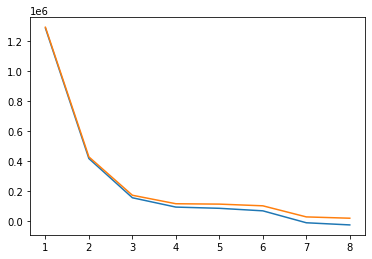

In [ ]:
#prueba con mezcla de gaussianas aplicado sobre datos transformados con PCA

bic = []
aic = []
for i in range(8):
    gm = GaussianMixture(
                     n_components = i+1,
                     n_init = 10,
                     max_iter = 100)
    gm.fit(text_pca)
    bic.append(gm.bic(text_pca))
    aic.append(gm.aic(text_pca))

fig = plt.figure()
plt.plot([1,2,3,4,5,6,7,8], aic)
plt.plot([1,2,3,4,5,6,7,8], bic)
plt.show()

In [ ]:
gmm_pca = GaussianMixture(n_components = 3, random_state =0) 
gmm_pca.fit(text_pca)

GaussianMixture(n_components=3, random_state=0)

In [ ]:
print(gmm_pca.means_)

[[-12.06353511   3.85546896  -2.86880632  -3.65989052   0.46729429
    0.91755028   0.39348092   0.31695489   0.50622204   0.98573565
   -0.28284809   0.65355218  -0.20890615  -0.05739793  -0.39844618
   -0.50078952   0.45483822  -0.12281336  -0.05287839   0.37410981
   -0.0893453    0.1678736    0.25508219   0.08196755  -0.00917359
    0.11577026  -0.27319643   0.07941084  -0.09137762   0.02976533
    0.20266163   0.09397962  -0.05792923  -0.11973993   0.08109072
    0.03035013   0.04055857  -0.00566126   0.04381625   0.08785307]
 [ 59.17008384  -4.02423708  -6.60384757  -4.45454024  -0.5899634
    9.00354768   2.82029726  -1.99451378   1.47562214   3.39420122
   -0.46632648   2.77023138  -1.02865572   0.05189216   0.84485084
   -0.72744572  -0.07209706  -0.44672928   0.30794123   0.02732166
    0.02845743   1.12110651  -0.52086596   0.43952155  -0.42111145
   -0.17433644   1.71851122  -0.08360338   0.7174631    0.05241382
   -0.73166987  -0.43573404  -0.09644445  -0.56680793  -0.0760

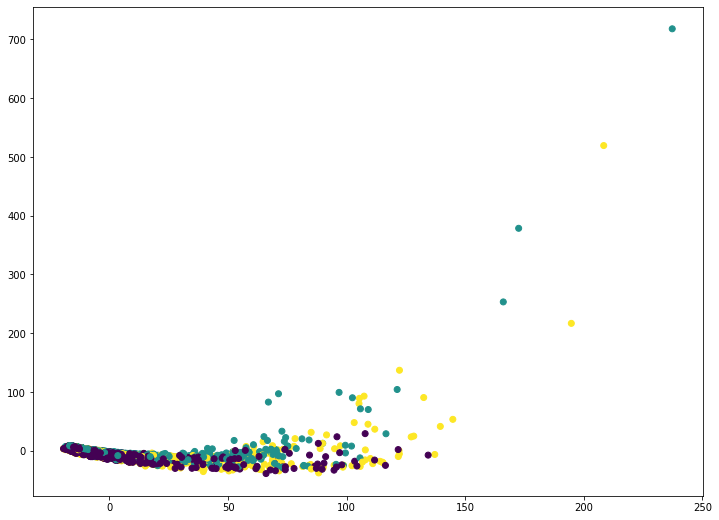

In [ ]:
from scipy.stats import multivariate_normal as mvn

predicted_values = gmm_pca.predict(text_pca)
    
plt.figure(figsize = (12,9))
plt.scatter(text_pca[:, 0], text_pca[:, 1],c=y , cmap='viridis')

#plt.scatter(centers[:, 0], centers[:, 1],c='black', alpha=0.6);

En el grafico anterior se observan los datos transformados con PCA, y cada color corresponde a una clase (neutral, positiva, negativa)

In [ ]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5", 
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

output_notebook()
plot_pca = bp.figure(plot_width=900, plot_height=700, title="Clusters con datos en PCA",
    tools="pan,wheel_zoom,box_zoom,reset,hover",
    x_axis_type=None, y_axis_type=None, min_border=1)

plot_pca.scatter(x=text_pca[:,0], y=text_pca[:,1], 
                    color=colormap[predicted_values][:10000]) 
                   
hover = plot_pca.select(dict(type=HoverTool))

show(plot_pca)

Podemos observar que utilizando transformacion con PCA los datos se separan mejor.

In [ ]:
#Gaussian Mixture clustering con t-sne


colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5", 
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

plot_gmm = bp.figure(plot_width=800, plot_height=700, title="Sentiment sobre distribucion sin PCA (Clusters con GMM)",
    tools="pan,wheel_zoom,box_zoom,reset,hover",
    x_axis_type=None, y_axis_type=None, min_border=1)

plot_gmm.scatter(x=tsne_kmeans[:,0], y=tsne_kmeans[:,1], 
                    color=colormap[predicted_values][:10000]) 
                   
hover = plot_gmm.select(dict(type=HoverTool))

show(plot_gmm)

In [ ]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_gmm = tsne_model.fit_transform(text_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4846 samples in 0.000s...
[t-SNE] Computed neighbors for 4846 samples in 0.715s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4846
[t-SNE] Computed conditional probabilities for sample 2000 / 4846
[t-SNE] Computed conditional probabilities for sample 3000 / 4846
[t-SNE] Computed conditional probabilities for sample 4000 / 4846
[t-SNE] Computed conditional probabilities for sample 4846 / 4846
[t-SNE] Mean sigma: 8.122241
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.681793
[t-SNE] KL divergence after 1000 iterations: 1.616245


In [ ]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5", 
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

plot_gmm = bp.figure(plot_width=800, plot_height=700, title="Sentiment_PCA (GMM Clusters)",
    tools="pan,wheel_zoom,box_zoom,reset,hover",
    x_axis_type=None, y_axis_type=None, min_border=1)

plot_gmm.scatter(x=tsne_gmm[:,0], y=tsne_gmm[:,1], 
                    color=colormap[predicted_values][:10000]) 
                   
hover = plot_gmm.select(dict(type=HoverTool))

show(plot_gmm)